In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [6]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 2000


In [7]:
np.sum(~np.all(lsbg_cat['image_flag'], axis=1))

25

In [94]:
lsbg = lsbg_cat[1421] # 12 # 69

In [95]:
lsbg

<Row index=1421>
viz-id         ra                 dec             mag_auto_i          sersic_n           sersic_ell         sersic_PA      sersic_rhalf_circ               sersic_sed [4]                              mags [4]                            prefix             image_flag [4] psf_flag [4]
int64       float64             float64            float64            float64             float64            float64            float64                       float64                                  float64                            bytes65                  bool          bool    
------ ------------------ ------------------- ------------------ ------------------ ------------------- ------------------ ------------------ ---------------------------------------- --------------------------------------- ------------------------------ -------------- ------------
  1421 185.47707447661085 0.24816412910211946 18.661134625658864 0.9237878196354403 0.41404521251327864 -69.02874809124096 10.108660103232118 0.5741141499244117 .. 1.1984718115271187 19.263638998524822 .. 18.46456506632666 ./Cutout/mock_sample/mock_1421   True .. True True .. True

In [ ]:
python deploy_mock.py --name mock_wvlt --ncpu=10 --starlet_thresh=0.3 \
 --method=wavelet --low=1000 --high=1500 --monotonic=True \
 --variance=0.000225 --min_grad 0.01 \
 --scales="[0, 1, 2, 3, 4]" --sigma=0.02

In [96]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [110]:
fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
                       starlet_thresh=0.3, min_grad=0.01,
                       monotonic=True, bkg=True,
                       variance=0.015**2, 
                       scales=[0, 1, 2, 3, 4],
                       model_dir='./Model/mock_sample/',
                       figure_dir='./Figure/mock_sample',
                       log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

In [ ]:
python deploy_mock.py --name mock_wvlt --ncpu=16 --starlet_thresh=0.3 \
 --method=wavelet --low=0 --high=500 --monotonic=True --bkg=True \
 --variance=0.000225 --min_grad=0.01  --sigma=0.02 \
 --scales="[0, 1, 2, 3, 4]"

In [ ]:
python deploy_mock.py --name mock_wvlt --ncpu=16 --starlet_thresh=0.3 \
 --method=wavelet --low=0 --high=500 --monotonic=True --bkg=True \
 --variance=0.000225 --min_grad 0.01 \
 --scales="[0, 1, 2, 3, 4]" --sigma=0.02

#### Step-by-step

In [11]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    10 stars from Gaia are masked!


In [12]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 214 objects


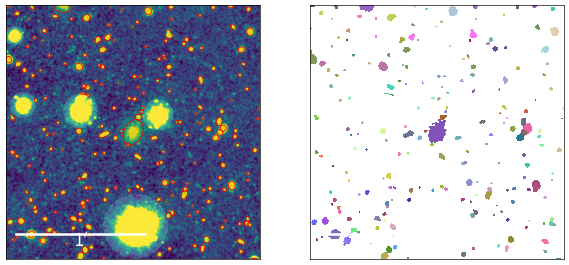

In [13]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont)

In [14]:
import scarlet.initialization as init

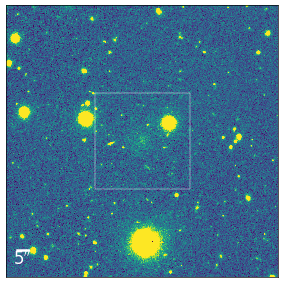

In [15]:
fitter._estimate_box(fitter.cen_obj)

In [16]:
fitter._mask_stars_outside_box()

    9 stars from Gaia are masked!


    Detected 137 objects


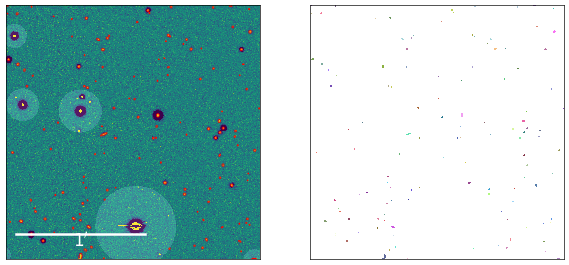

In [17]:
fitter._cpct_obj_detection()

In [18]:
from kuaizi.display import draw_circles

    Detected 67 objects


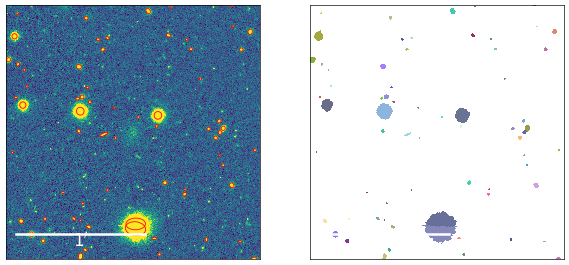

In [19]:
fitter._big_obj_detection()

In [20]:
fitter._merge_catalogs()

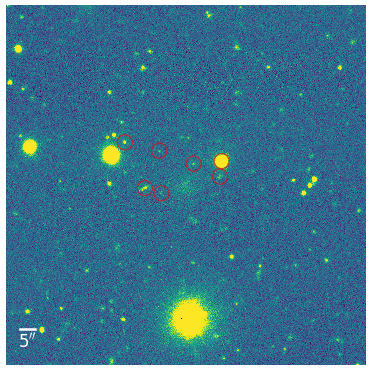

In [21]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [22]:
fitter._construct_obs_frames()

In [23]:
if fitter.bright:
    fitter.variance = 0.05**2
    fitter.scales = [0, 1, 2, 3, 4, 5, 6]
    fitter.starlet_thresh = 0.5
    fitter.min_grad = 0.02

fitter._add_sources(min_grad=fitter.min_grad, thresh=0.1)

  - Wavelet modeling with the following hyperparameters:
    min_grad = 0.01, starlet_thresh = 0.30 (contam_ratio = 0.04), 
     monotonic = True, variance = 0.00022, scales = [0, 1, 2, 3, 4].
    Total number of sources: 17


In [24]:
new_source = scarlet.RandomSource(
    fitter.model_frame, 
    fitter.observation)
fitter._sources.append(new_source)
fitter.blend = scarlet.Blend(fitter._sources, fitter.observation)

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

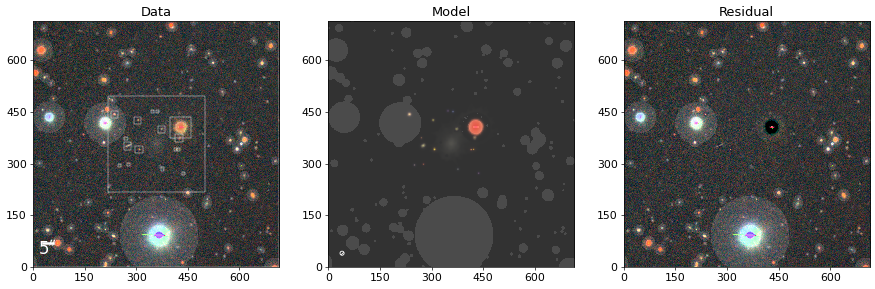

In [25]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

In [423]:
# fitter.blend.fit(10)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 179 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 219 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 239 iterations! Try higher accuracy!
  - After 205 iterations, logL = 2068790.87
    Elapsed time for fitting: 59.44 s


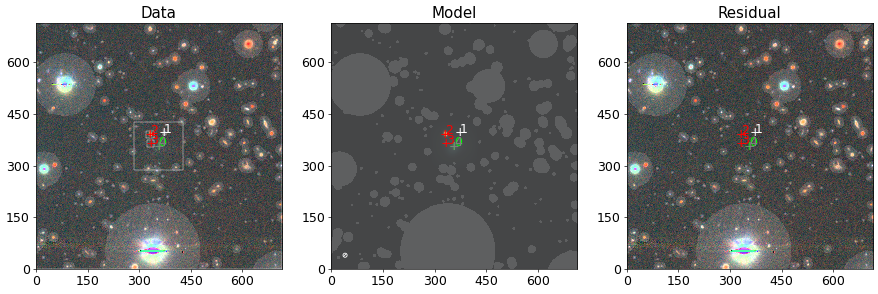

In [15]:
try:
    fitter._optimize()
#     fitter._optimize()
except:
    pass

In [18]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
except:
    pass

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-1245-trained-model-wavelet.df


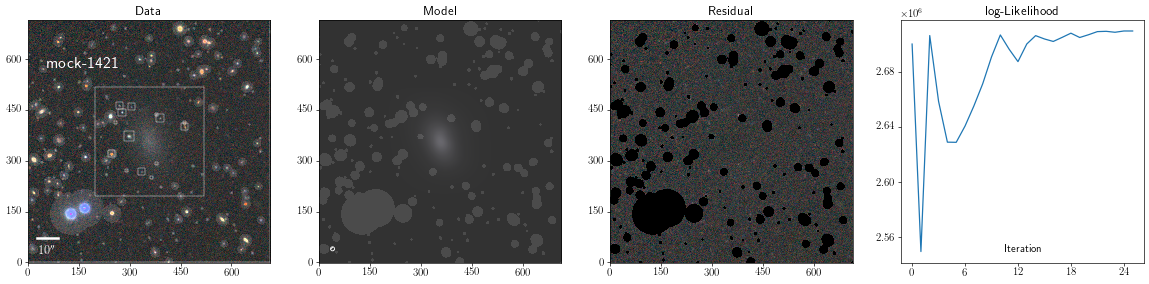

In [99]:
fitter._display_results()

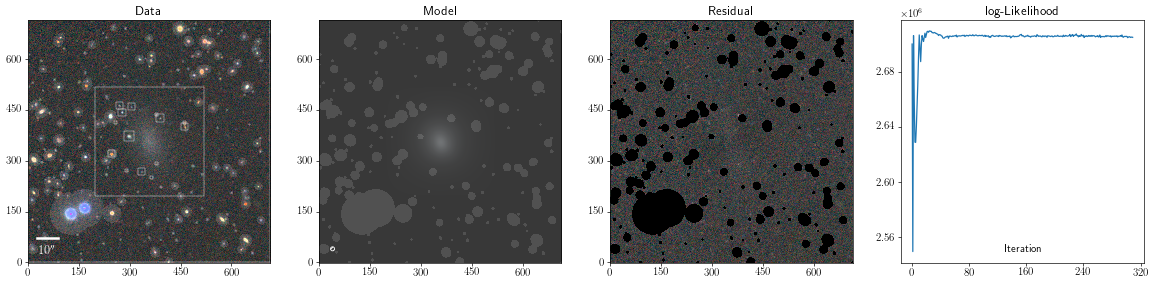

In [100]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
        show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.8,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [21]:
morph = fitter.blend.sources[0].morphology

In [99]:
morph.shape

(8, 391, 391)

In [1396]:
from scarlet import Starlet

In [1397]:
s = Starlet.from_coefficients(morph)

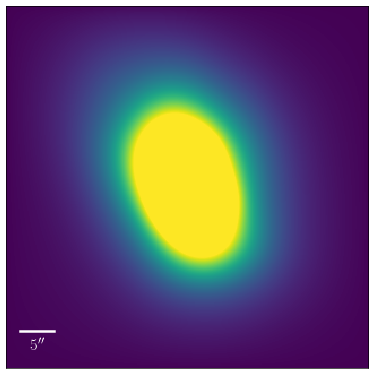

In [103]:
# display_single(s.image, scale='linear');
model = fitter.blend.sources[0].get_model()
display_single(fitter.observation.render(model)[0]);
# model.mean()

In [36]:
from scarlet.operator import prox_monotonic_mask

In [36]:
src = fitter.blend.sources[0]
morph = src.morphology
img = src.get_model()
img = fitter.observation.render(img)
center = tuple(s // 2 for s in src.bbox.shape[1:])

In [42]:
prox = prox_monotonic_mask(
    img[0], 1e-3, 
    center=center,
    zero=0,
            center_radius=2,
            variance=1e-5,
            max_iter=10)
print(prox[2])
print(np.sum(~prox[0]))

[  0 270   0 270]
9629


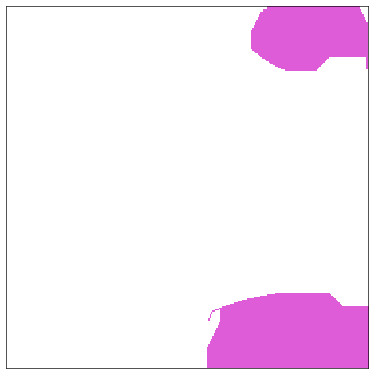

In [43]:
display_single((~prox[0]).astype(float), cmap=SEG_CMAP, scale='linear');

In [44]:
from astropy.convolution import convolve, Gaussian2DKernel

In [86]:
smooth_radius = 4
gaussian_threshold = 0.02
mask_conv = np.copy(~prox[0])
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
mask_conv = (mask_conv > gaussian_threshold)
monomask = np.zeros(fitter.blend.bbox.shape[1:])
monomask[src.bbox.origin[1]:src.bbox.origin[1] + src.bbox.shape[1],
         src.bbox.origin[2]:src.bbox.origin[2] + src.bbox.shape[2]] = mask_conv
monomask = monomask.astype(bool)

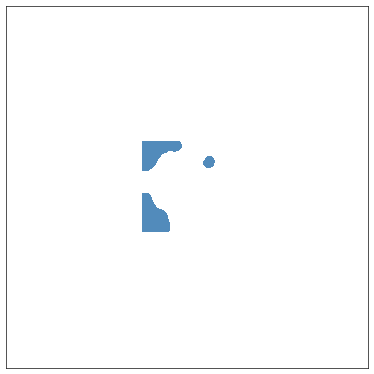

In [87]:
display_single(monomask.astype(float), cmap=SEG_CMAP, scale='linear');

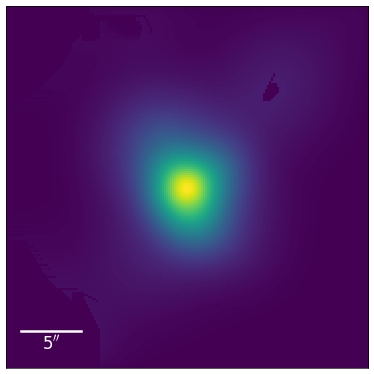

In [88]:
display_single((prox[1]).astype(float), scale='linear');

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

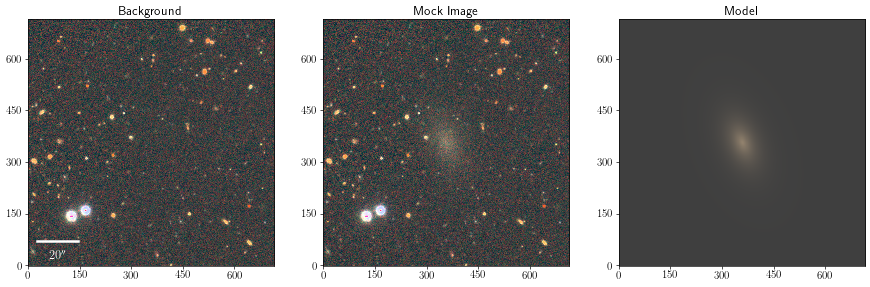

In [112]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [113]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

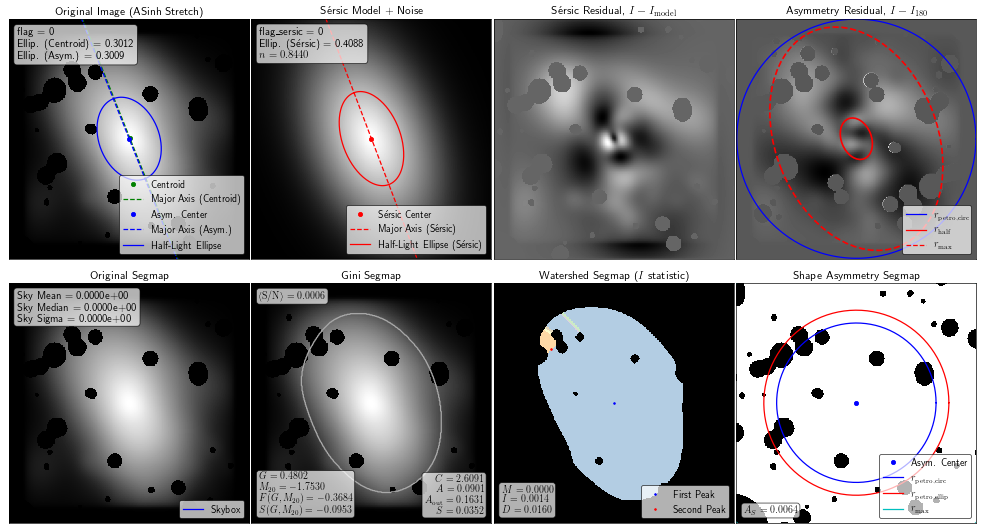

In [114]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

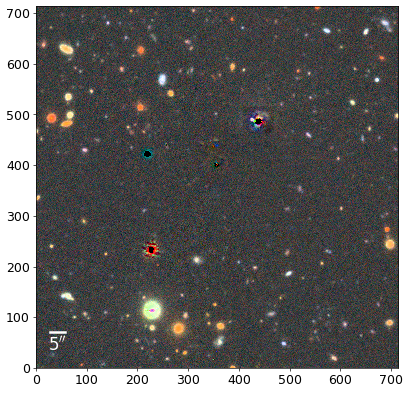

In [77]:
display_rgb(gal.mock.images - fitter.observation.render(fitter.blend.get_model()), stretch=0.8);

In [116]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

9.289072680847504
10.108660103232118


10.608014715375962

In [117]:
measurement['SB_eff_avg'], measurement['mag']

(array([26.230133, 25.786354, 25.57475 , 25.549597], dtype=float32),
 array([19.355408, 18.91163 , 18.700027, 18.674873], dtype=float32))

In [118]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([19.394821, 18.951042, 18.73944 , 18.714285], dtype=float32)

In [119]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(19.263638998524822, 18.841166536948183, 18.661134625658864)

In [120]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.30086160668879347, 0.41404521251327864)

In [746]:
from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

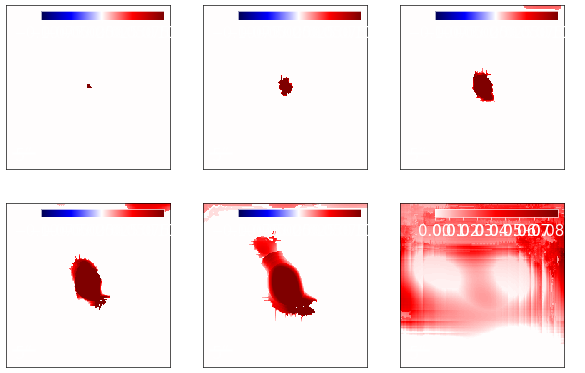

In [747]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
    axes[i//3, i%3] = display_single(morph[i+1], ax=axes[i//3, i%3],
                                     color_bar=True, cmap='seismic', norm=divnorm);

In [480]:
import PIL.Image

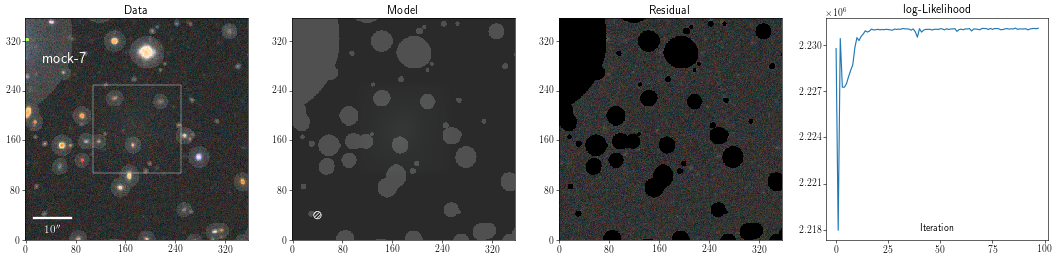

In [481]:
PIL.Image.open('./Figure/mock_sample/mock-7-zoomin-wavelet.png')

In [638]:
truth_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')
truth_cat[(truth_cat['ellip'] > 0.3) & (truth_cat['SB_eff_g'] > 27)]['viz-id'][30:50]

<Column name='viz-id' dtype='int64' length=20>
168
173
177
178
179
182
187
199
200
201
204
205
238
251
257
261
266
268
276
286

In [223]:
fits.open('./Cutout/mock_sample/bkg/mockbkg_1001_r.fits')[1].data.shape

(715, 715)